## Import packages

In [1]:
#image analysis
import skimage.io
import imageio
import alienlab.plot
from alienlab.improcessing import normalize, grey_to_rgb, make_binary
import alienlab.segment
from alienlab.fo import FramesOperator
import alienlab.io


#interactive widget packages
from ipywidgets import interact, interactive, fixed, interact_manual
from tkinter.filedialog import askopenfilename


import time
import os
import numpy as np
import matplotlib.pyplot as plt



%matplotlib inline

## Import video file

In [2]:
showit = True #option to output intermediary images in the segmentation process

# Import video file in HQ and select ROI
file_path = askopenfilename(title = 'Select a video file') # pops up a window to select your file

direc = os.path.split(file_path)[0]

# Initialize plotting tools
g = alienlab.plot.ShowFigure()
g.figsize = (15,7)
g.save_folder = direc
g.date = False
p = alienlab.plot.PlotFigure()
p.figsize = (15,7)
p.save_folder = direc
p.date = False

## Pre-process the video

--- Computed frames statistics in 0.715184 seconds ---


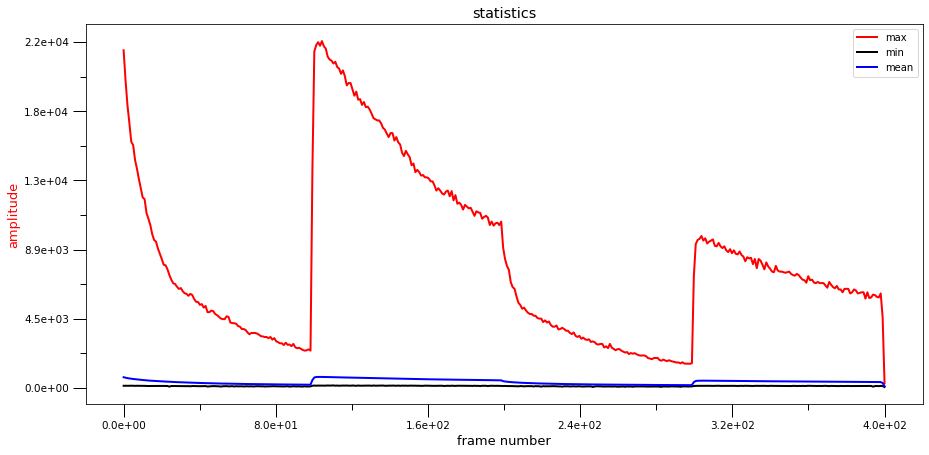

In [3]:
# read the stacked frame. dim = NxHxW (N images in the video, Heigt, Width)

frames_full = skimage.io.imread(file_path) 
FO = FramesOperator(frames_full)
im = normalize(FO.frames[0], 0, 1)
im = grey_to_rgb(im)*255

y, x = alienlab.io.select_roi(np.uint8(im)) #select area of interest
FO.x = x
FO.y = y
FO.crop() #crop image

start_time = time.time()
FO.compute_stats() #compute various statistical values on the frames and the pixels
FO.normalize(0, 1)
print("--- Computed frames statistics in %04f seconds ---" % (time.time() - start_time))

#FO.global_stats: each array has size N, number of frames and represents the stats of each frame
#FO.frames_stats: each array has size FO.x, FO.y and is an image representing the N frames stats overlayed

if showit:
    p.title = 'statistics'
    p.xlabel = 'frame number'
    p.ylabel = 'amplitude'
    p.label_list = ['max', 'min', 'mean', 'std']
    fig = p.plotting(np.asarray(FO.inds), [FO.global_stats['max'], 
                        FO.global_stats['min'], 
                        FO.global_stats['mean']])
    p.save_name = 'frames_stats'
    p.saving(fig)

''' IMAGE SEGMENTATION '''

# selection of the frames with high dynamics that will be used for the image segmentation process.
# Let M be the highest value taken by a pixel in all the frames of the video. The frame F is kept for processing only if at
# least one pixel in the frame F has a value above 0.8*M. 
FO.selected_inds = FO.select_frames(FO.global_stats['max'], FO.global_stats['max'].max()*0.8)


### Show reference image

(-0.5, 270.5, 215.5, -0.5)

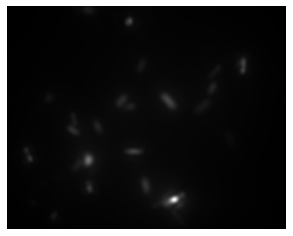

In [8]:
plt.figure(figsize = (5, 5))
plt.imshow(FO.frames[FO.selected_inds].sum(axis = 0), cmap = 'gray')
plt.axis('off')

## Image segmentation

In [16]:
def segment_image(contrast, autolevel, dist_max, dist_seg, disk_size, max_contrast):
    
    start_time = time.time()
    FO.selected_inds = FO.select_frames(FO.global_stats['max'], FO.global_stats['max'].max()*0.8) # Select only images with high intensity to increase contrast and lower computation time

    #apply contrast filter to all frames
    frames_contrast = FO.apply(skimage.filters.rank.enhance_contrast,  selem = skimage.morphology.disk(contrast))
    #apply autolevel filter to all frames
    frames_autolevel = FO.apply(skimage.filters.rank.autolevel, selem = skimage.morphology.disk(autolevel))
    #sum the contrast images to get a reference grey-level contrast image
    frame_contrast = np.sum(frames_contrast, axis = 0)
    #sum the autolevel images to get a reference grey-level autolevel image
    frame_autolevel = np.sum(frames_autolevel, axis = 0)
    #obtain contrast mask from reference contrast image
    mask_contrast = make_binary(frame_contrast, soft_hard = 1)
    #otbain autolevel mask from reference autolevel image
    mask_autolevel =  make_binary(frame_autolevel, soft_hard = 1)
    #intersection of contrast aud autolevel masks
    mask_intersect = mask_contrast * mask_autolevel
    #clean the masks with a binary opening
    mask_intersect = skimage.morphology.binary_opening(mask_intersect, selem = skimage.morphology.disk(disk_size))
    #reference image of altitude for the watershed
    auto_contrast = normalize(mask_intersect * frame_autolevel)
    print("--- Computed binary mask in %04f seconds ---" % (time.time() - start_time))


    if showit:
        g.figsize = (40,15)
        g.title_list = 'mask intersect', 'contrast', 'contrast threshold', 'autolevel', 'autolevel threshold','segmentation image'
        g.col_num = 3
        fig = g.multi([mask_intersect, frame_contrast, mask_intersect, 
                       frame_autolevel, mask_autolevel, auto_contrast])
        g.save_name = 'Segmentation reference'
        g.saving(fig)

    start_time = time.time()
    ref = auto_contrast
    mask = mask_intersect
    #locate the local maxima
    local_maxi = alienlab.segment.local_maxima(auto_contrast, max_contrast, g,
                                                     ref_distance = dist_max, mask = mask, show = showit)
    #perform watershed segmentation
    watershed_im_mask = alienlab.segment.watershed(ref, mask, local_maxi,
                                                         g, ref_distance = dist_seg, show = showit)
    segmented = watershed_im_mask
    print("--- Computed segmentation in %04f seconds ---" % (time.time() - start_time))

    if showit:
        alienlab.segment.show_segmentation(FO, segmented, g)
    #return mask, FO


In [17]:
interact(segment_image, contrast = (1, 4), autolevel = (1, 10), dist_max = False, dist_seg = False, disk_size = (1, 4), max_contrast = (1,10), soft_hard = (0.1, 1.9))

interactive(children=(IntSlider(value=2, description='contrast', max=4, min=1), IntSlider(value=5, description…

<function __main__.segment_image(contrast, autolevel, dist_max, dist_seg, disk_size, max_contrast)>